In [1]:
import os
import pickle
import copy
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tqdm import tqdm
from rdkit.Geometry.rdGeometry import Point3D
from rdkit import Chem
from ccdc.conformer import ConformerGenerator, MoleculeMinimiser
from ccdc.molecule import Molecule
from ConformationEnsemble import ConformationEnsembleLibrary
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds, CalcExactMolWt
from rdkit.Chem.Lipinski import NumHAcceptors, NumHDonors
from rdkit.Chem.Crippen import MolLogP
from sklearn.manifold import TSNE
from rdkit.Chem import AllChem

In [2]:
# To be able to save conformer properties
Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps) 

In [3]:
data_dir_path = 'data/'

In [4]:
sdsupplier = Chem.rdmolfiles.SDMolSupplier(os.path.join(data_dir_path, 'platinum-dataset-2017-01-sdf', 'platinum_dataset_2017_01.sdf'))
platinum_mols = [mol for mol in sdsupplier]

In [5]:
len(platinum_mols)

4548

In [6]:
# To be able to save conformer properties
Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)

In [7]:
data_dir_path = 'data/'

In [8]:
with open(os.path.join(data_dir_path, 'raw', 'pdbbind_general_conf_ensemble_library.p'), 'rb') as f :
    general_CEL = pickle.load(f)

In [9]:
with open(os.path.join(data_dir_path, 'raw', 'pdbbind_refined_conf_ensemble_library.p'), 'rb') as f :
    refined_CEL = pickle.load(f)

In [10]:
all_CEL = general_CEL
all_CEL.merge(refined_CEL)

In [11]:
pdbbind_mols = []
for smiles, conf_ensemble in tqdm(all_CEL.get_unique_molecules()) :
    pdbbind_mols.append(conf_ensemble.mol)

100%|████████████████████████████████| 12349/12349 [00:00<00:00, 3792038.96it/s]


In [12]:
parsed_pdbbind_mols = []
for mol in pdbbind_mols :
    try :
        parsed_pdbbind_mols.append(Chem.RemoveHs(mol))
    except :
        print('error')

RDKit ERROR: [12:35:23] Explicit valence for atom # 9 Br, 3, is greater than permitted
[12:35:23] Explicit valence for atom # 9 Br, 3, is greater than permitted


error
error


RDKit ERROR: [12:35:24] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[12:35:24] Explicit valence for atom # 0 Cl, 3, is greater than permitted


In [13]:
parsed_platinum_mols = []
for mol in platinum_mols :
    try :
        parsed_platinum_mols.append(Chem.RemoveHs(mol))
    except :
        print('error')

In [14]:
pdbbind_smiles = []
for mol in parsed_pdbbind_mols :
    try :
        pdbbind_smiles.append(Chem.MolToSmiles(mol))
    except :
        print('error')
        
platinum_smiles = [Chem.MolToSmiles(mol) for mol in parsed_platinum_mols]

In [15]:
len(set(pdbbind_smiles).intersection(set(platinum_smiles)))

964

In [16]:
common_mols = []
for i, mol in enumerate(parsed_pdbbind_mols) :
    if pdbbind_smiles[i] in platinum_smiles :
        common_mols.append(mol)

In [17]:
datasets = {'PDBBind': parsed_pdbbind_mols, 'Platinum' : platinum_mols, 'Common' : common_mols}

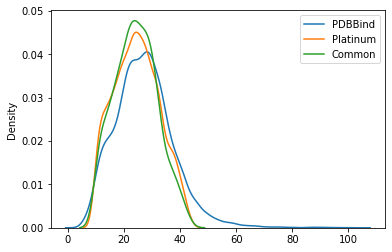

In [18]:
for dataset_name, dataset in datasets.items() :
    n_heavy_atoms = [mol.GetNumHeavyAtoms() for mol in dataset]
    sns.kdeplot(n_heavy_atoms, label=dataset_name)
plt.legend()
plt.show()

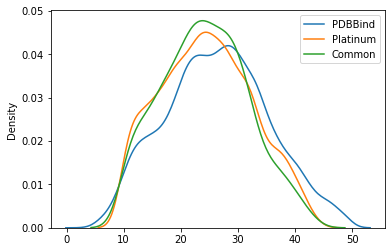

In [19]:
for dataset_name, dataset in datasets.items() :
    n_heavy_atoms = [mol.GetNumHeavyAtoms() for mol in dataset if mol.GetNumHeavyAtoms() < 50]
    sns.kdeplot(n_heavy_atoms, label=dataset_name)
plt.legend()
plt.show()

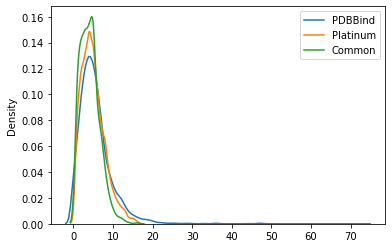

In [20]:
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds
for dataset_name, dataset in datasets.items() :
    n_rot_bonds = [CalcNumRotatableBonds(mol) for mol in dataset]
    sns.kdeplot(n_rot_bonds, label=dataset_name)
plt.legend()
plt.show()

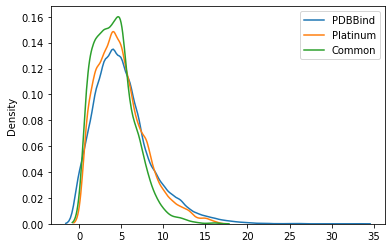

In [21]:
for dataset_name, dataset in datasets.items() :
    n_rot_bonds = [CalcNumRotatableBonds(mol) for mol in dataset if mol.GetNumHeavyAtoms() < 50]
    sns.kdeplot(n_rot_bonds, label=dataset_name)
plt.legend()
plt.show()

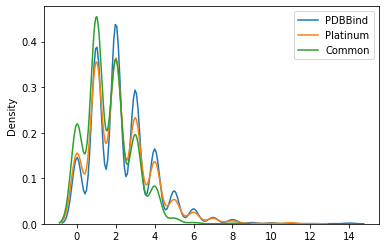

In [22]:
for dataset_name, dataset in datasets.items() :
    n_hbd = [NumHDonors(mol) for mol in dataset if mol.GetNumHeavyAtoms() < 50]
    sns.kdeplot(n_hbd, label=dataset_name)
plt.legend()
plt.show()

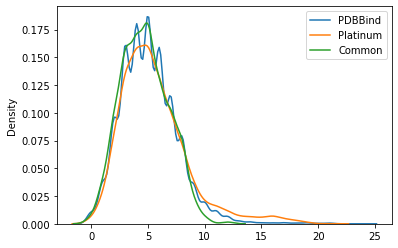

In [23]:
for dataset_name, dataset in datasets.items() :
    n_hba = [NumHAcceptors(mol) for mol in dataset if mol.GetNumHeavyAtoms() < 50]
    sns.kdeplot(n_hba, label=dataset_name)
plt.legend()
plt.show()

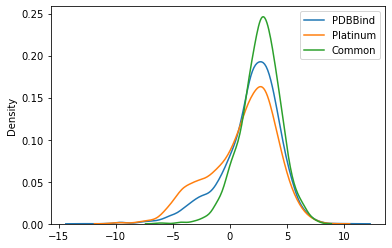

In [24]:
for dataset_name, dataset in datasets.items() :
    log_ps = [MolLogP(mol) for mol in dataset if mol.GetNumHeavyAtoms() < 50]
    sns.kdeplot(log_ps, label=dataset_name)
plt.legend()
plt.show()

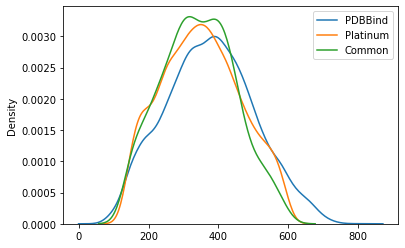

In [25]:
for dataset_name, dataset in datasets.items() :
    mws = [CalcExactMolWt(mol) for mol in dataset if mol.GetNumHeavyAtoms() < 50]
    sns.kdeplot(mws, label=dataset_name)
plt.legend()
plt.show()

In [26]:
pdbbind_fps = [AllChem.GetMorganFingerprintAsBitVect(mol,3) for mol in parsed_pdbbind_mols]
platinum_fps = [AllChem.GetMorganFingerprintAsBitVect(mol,3) for mol in parsed_platinum_mols]

In [27]:
all_fps = pdbbind_fps + platinum_fps
all_fps = np.array(all_fps)

In [28]:
tsne = TSNE(n_components=2, verbose=1, metric='dice')
xy = tsne.fit_transform(all_fps)

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16895 samples in 0.010s...


/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


[t-SNE] Computed neighbors for 16895 samples in 131.601s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16895
[t-SNE] Computed conditional probabilities for sample 2000 / 16895
[t-SNE] Computed conditional probabilities for sample 3000 / 16895
[t-SNE] Computed conditional probabilities for sample 4000 / 16895
[t-SNE] Computed conditional probabilities for sample 5000 / 16895
[t-SNE] Computed conditional probabilities for sample 6000 / 16895
[t-SNE] Computed conditional probabilities for sample 7000 / 16895
[t-SNE] Computed conditional probabilities for sample 8000 / 16895
[t-SNE] Computed conditional probabilities for sample 9000 / 16895
[t-SNE] Computed conditional probabilities for sample 10000 / 16895
[t-SNE] Computed conditional probabilities for sample 11000 / 16895
[t-SNE] Computed conditional probabilities for sample 12000 / 16895
[t-SNE] Computed conditional probabilities for sample 13000 / 16895
[t-SNE] Computed conditional probabilities for sample 14000 / 168

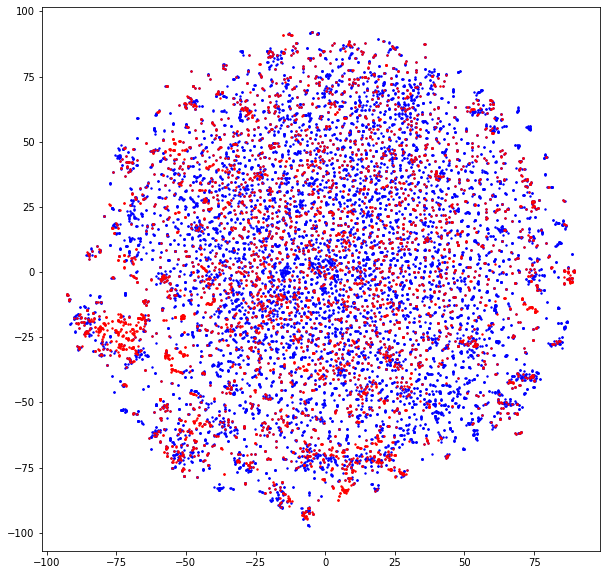

In [29]:
plt.figure(figsize=(10, 10))
plt.scatter(xy[:len(pdbbind_fps), 0], xy[:len(pdbbind_fps), 1], s=2, c='blue')
plt.scatter(xy[len(pdbbind_fps):, 0], xy[len(pdbbind_fps):, 1], s=2, c='red')
plt.show()